# Semi-Supervised Conditional GAN (SCGAN)

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import json
import time

from keras import backend as K
import tensorflow as tf
import keras

from keras.datasets import mnist
from keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                          Dropout, Flatten, Input, Lambda, Reshape, Embedding,
                          Multiply)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


## Dataset

In [0]:
class Dataset:
    def __init__(self, num_labeled):

        # Number labeled examples to use for training
        self.num_labeled = num_labeled

        # Load the MNIST dataset
        (self.x_train, self.y_train), (self.x_test,
                                       self.y_test) = mnist.load_data()

        def preprocess_imgs(x):
            # Rescale [0, 255] grayscale pixel values to [-1, 1]
            x = (x.astype(np.float32) - 127.5) / 127.5
            # Expand image dimensions to width x height x channels
            x = np.expand_dims(x, axis=3)
            return x

        def preprocess_labels(y):
            return y.reshape(-1, 1)

        # Training data
        self.x_train = preprocess_imgs(self.x_train)
        self.y_train = preprocess_labels(self.y_train)

        # Testing data
        self.x_test = preprocess_imgs(self.x_test)
        self.y_test = preprocess_labels(self.y_test)

    def batch_labeled(self, batch_size):
        # Get a random batch of labeled images and their labels
        idx = np.random.randint(0, self.num_labeled, batch_size)
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs, labels

    def batch_unlabeled(self, batch_size):
        # Get a random batch of unlabeled images
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0],
                                batch_size)
        imgs = self.x_train[idx]
        return imgs

    def training_set(self):
        x_train = self.x_train[range(self.num_labeled)]
        y_train = self.y_train[range(self.num_labeled)]
        return x_train, y_train

    def test_set(self):
        return self.x_test, self.y_test

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


## Check the data

In [0]:
# Training set

d_ytrain = {}
for i in range(10):
  d_ytrain[i] = 0
for i in range(len(y_train)):
  d_ytrain[y_train[i]] = d_ytrain.get(y_train[i]) + 1
print(d_ytrain)

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


In [0]:
# Test set

d_ytest = {}
for i in range(10):
  d_ytest[i] = 0
for i in range(len(y_test)):
  d_ytest[y_test[i]] = d_ytest.get(y_test[i]) + 1
print(d_ytest)

{0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


# Semi-Supervied GAN

In [0]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

# Number of classes in the dataset
num_classes = 10

## Generator

In [0]:
def build_generator(z_dim):
  
    z = Input(shape=(z_dim, ))
    label = Input(shape=(num_classes, ), dtype='float32')
    label_embedding = Dense(z_dim, input_dim=num_classes)(label)
    print(label_embedding)
    joined_representation = Multiply()([z, label_embedding])
    
#     model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    model = Dense(256 * 7 * 7, input_dim=z_dim)(joined_representation)
    model = Reshape((7, 7, 256))(model)

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(model)

    # Batch normalization
    model = BatchNormalization()(model)

    # Leaky ReLU activation
    model = LeakyReLU(alpha=0.01)(model)

    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model = Conv2DTranspose(64, kernel_size=3, strides=1, padding='same')(model)

    # Batch normalization
    model = BatchNormalization()(model)

    # Leaky ReLU activation
    model = LeakyReLU(alpha=0.01)(model)

    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model = Conv2DTranspose(1, kernel_size=3, strides=2, padding='same')(model)

    # Output layer with tanh activation
    conditioned_img = Activation('tanh')(model)
    
#     conditioned_img = model(joined_representation)

    model = Model([z, label], conditioned_img)

    return model

In [7]:
build_generator(z_dim).summary()




Tensor("dense_1/BiasAdd:0", shape=(?, 100), dtype=float32)








Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          1100        input_2[0][0]                    
__________________________________________________________________________________________________
multiply_1 (Multiply)           (None, 100)          0           input_1[0][0]                    
                      

## Discriminator

In [0]:
def build_discriminator_net(img_shape):

    model = Sequential()

    # Convolutional layer, from 28x28x1 into 14x14x32 tensor
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 14x14x32 into 7x7x64 tensor
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Droupout
    model.add(Dropout(0.5))

    # Flatten the tensor
    model.add(Flatten())

    # Fully connected layer with num_classes neurons
    model.add(Dense(num_classes))

    return model

In [0]:
def build_discriminator_class(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    # Softmax activation, giving predicted probability distribution over the real classes
    model.add(Activation('softmax'))

    return model

In [0]:
def build_discriminator_realOfFake(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    def predict(x):
        # Transform distribution over real classes into a binary real-vs-fake probability
        prediction = 1.0 - (1.0 / (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
        return prediction

    # 'Real-vs-fake' output neuron defined above
    model.add(Lambda(predict))

    return model

## Build the Model

In [0]:
def build_gan(generator, discriminator):
    
    z = Input(shape=(z_dim, ))
    label = Input(shape=(num_classes, ))
    img = generator([z, label])
    output = discriminator(img)
    model = Model([z, label], output)

    return model

### Discriminator

In [0]:
# Core Discriminator network:
# These layers are shared during supervised and unsupervised training

discriminator_net = build_discriminator_net(img_shape)
discriminator_realOrFake = build_discriminator_realOfFake(discriminator_net)
discriminator_class = build_discriminator_class(discriminator_net)

discriminator_class.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())
discriminator_realOrFake.compile(loss='binary_crossentropy',metrics=['accuracy'], optimizer=Adam())

# def loss_d_realOrFake(pred, label):
#   # label = [1,1,...,1] or [0,0,...,0]
#   def predict_real_of_fake(x):
#       prediction = 1.0 - (1.0 / (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
#       return prediction
#   pred_realOrFake = predict_real_of_fake(pred)
#   # loss = tf.keras.losses.binary_crossentropy(pred_realOrFake, label)
#   loss_realOrFake = keras.losses.mean_squared_error(pred_realOrFake, label)
#   return loss_realOrFake

# def loss_d_class(pred, label):
#   # label: {0,1,...9}
#   def softmax(x): 
#     e_x = K.exp(x - K.max(x)) 
#     return e_x / K.sum(e_x)
#   pred_class = softmax(pred)
#   loss_class = K.categorical_crossentropy(pred_class, label)
#   return loss_class

# discriminator_realOrFake.compile(loss=loss_d_labeled_realOrFake, metrics=['accuracy'], optimizer=Adam())
# discriminator_class.compile(loss=loss_d_labeled_class, metrics=['accuracy'], optimizer=Adam())

### Generator

In [25]:
# Build the Generator
generator = build_generator(z_dim)

discriminator_realOrFake.trainable = False
discriminator_class.trainable = False

gan_realOrFake = build_gan(generator, discriminator_realOrFake)
gan_class = build_gan(generator, discriminator_class)

gan_class.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam())
gan_realOrFake.compile(loss='binary_crossentropy',metrics=['accuracy'], optimizer=Adam())

# def loss_g_realOrFake(pred, label):
#   # "pred" is the second last of Discriminator
#   # label = [1,1,...,1] or [0,0,...,0]
#   def predict_real_of_fake(x):
#       prediction = 1.0 - (1.0 / (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
#       return prediction
#   pred_realOrFake = predict_real_of_fake(pred)
#   # loss = tf.keras.losses.binary_crossentropy(pred_realOrFake, label)
#   loss_realOrFake = keras.losses.mean_squared_error(pred_realOrFake, label)
#   return loss_realOrFake

# def loss_g_class(pred, label):
#   # label: {0,1,...9}
#   def softmax(x): 
#     e_x = K.exp(x - K.max(x)) 
#     return e_x / K.sum(e_x)
#   pred_class = softmax(pred)
#   loss_class = K.categorical_crossentropy(pred_class, label)
#   return loss_class

# gan_realOrFake.compile(loss=loss_g_realOrFake, metrics=['accuracy'], optimizer=Adam())
# gan_class.compile(loss=loss_g_class, metrics=['accuracy'], optimizer=Adam())

Tensor("dense_9/BiasAdd:0", shape=(?, 100), dtype=float32)


In [0]:
%mkdir images

In [0]:
plot_model(generator,to_file="images/model_generator.png",show_shapes=True)

In [0]:
plot_model(discriminator_net,to_file="images/discriminator_net.png",show_shapes=True)

In [0]:
plot_model(discriminator_supervised,to_file="images/model_discriminator_supervised.png",show_shapes=True)

In [0]:
plot_model(discriminator_unsupervised,to_file="images/model_discriminator_unsupervised.png",show_shapes=True)

In [0]:
plot_model(gan,to_file="images/model_gan.png",show_shapes=True)

## Training

In [0]:
%mkdir models
%mkdir losses
%mkdir models/models-label-100
%mkdir losses/losses-label-100

In [0]:
def train(iterations, batch_size, save_interval, k):

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        for _ in range(k):

            # -------------------------
            #  Train the Discriminator
            # -------------------------

            # discriminator_net.trainable = True

            # Get labeled examples
            imgs_labeled, labels = dataset.batch_labeled(batch_size)
            labels = to_categorical(labels, num_classes=num_classes)  # One-hot encode labels

            # Get unlabeled examples
            imgs_unlabeled = dataset.batch_unlabeled(batch_size)

            # Generate a batch of fake images
            z = np.random.normal(0, 1, (batch_size, z_dim))
            fake_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
            fake_labels = to_categorical(fake_labels, num_classes=num_classes)
            imgs_gen = generator.predict([z, fake_labels])

            # Train discriminator
            loss_d_labeled_realOrFake, acc_d_labeled_realOrFake = discriminator_realOrFake.train_on_batch(imgs_labeled, real)
            loss_d_unlabeled_realOrFake, acc_d_unlabeled_realOrFake = discriminator_realOrFake.train_on_batch(imgs_unlabeled, real)
            loss_d_gen_realOrFake, acc_d_gen_realOrFake = discriminator_realOrFake.train_on_batch(imgs_gen, fake)
            loss_d_labeled_class, acc_d_labeled_class = discriminator_class.train_on_batch(imgs_labeled, labels)
            loss_d_gen_class, acc_d_gen_class = discriminator_class.train_on_batch(imgs_gen, fake_labels)

            # Calculate loss and acc
            loss_d_train_realOrFake = np.add(loss_d_labeled_realOrFake, loss_d_unlabeled_realOrFake)
            loss_d_class = np.add(loss_d_labeled_class, loss_d_gen_class)
            loss_d_realOrFake = np.add(loss_d_gen_realOrFake, np.add(loss_d_labeled_realOrFake, loss_d_unlabeled_realOrFake))
            loss_d = np.add(loss_d_class, loss_d_realOrFake)
            acc_d_class = np.add(acc_d_labeled_class, acc_d_gen_class)/2.0
            acc_d_realOrFake = np.add(acc_d_gen_realOrFake, np.add(acc_d_labeled_realOrFake, acc_d_unlabeled_realOrFake))/3.0
            acc_d = np.add(acc_d_class, acc_d_realOrFake)/2.0

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Keep Discriminator’s parameters constant for Generator training
        # discriminator_net.trainable = False

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        fake_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        fake_labels = to_categorical(fake_labels, num_classes=num_classes)

        # Train Generator
        loss_g_realOrFake, acc_g_realOrFake = gan_realOrFake.train_on_batch([z, fake_labels], fake)
        loss_g_class, acc_g_class = gan_class.train_on_batch([z, fake_labels], fake_labels)

        # Calculate loss
        loss_g = np.add(loss_g_realOrFake, loss_g_class)

        if (iteration + 1) % save_interval == 0:

            # Save Discriminator supervised classification loss to be plotted after training
            losses_d_class.append(loss_d_class)
            losses_d_realOrFake.append(loss_d_realOrFake)
            losses_g_class.append(loss_g_class)
            losses_g_realOrFake.append(loss_g_realOrFake)
            
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print(
                "%d [D loss class: %.4f, acc: %.2f%%] [D loss realOrFake: %.4f, acc:%.2f%%] [G loss class: %.4f, acc: %.2f%%] [G loss realOrFake: %.4f, acc: %.2f%%]"
                % (iteration + 1, 
                    loss_d_class, 100 * acc_d_class,
                    loss_d_realOrFake, 100 * acc_d_realOrFake, 
                    loss_g_class, 100 * acc_g_class,
                    loss_g_realOrFake, 100 * acc_g_realOrFake))
            
            discriminator_class.save("./models/models-label-" + str(num_labeled) + "/discriminator_class-" + str(iteration+1) + ".h5")
            discriminator_realOrFake.save("./models/models-label-" + str(num_labeled) + "/discriminator_realOfFake-" + str(iteration+1) + ".h5")
            generator.save("./models/models-label-" + str(num_labeled) + "/generator-" + str(iteration+1) + ".h5")
            file1 = "./losses/losses-label-" + str(num_labeled) + "/losses_d_class.json"
            file2 = "./losses/losses-label-" + str(num_labeled) + "/losses_d_realOrFake.json"
            file3 = "./losses/losses-label-" + str(num_labeled) + "/losses_g_class.json"
            file4 = "./losses/losses-label-" + str(num_labeled) + "/losses_g_realOfFake.json"
            with open(file1, 'w') as json_file:
                  json.dump(str(losses_d_class), json_file)
            with open(file2, 'w') as json_file:
                  json.dump(str(losses_d_realOrFake), json_file)
            with open(file3, 'w') as json_file:
                  json.dump(str(losses_g_class), json_file)
            with open(file4, 'w') as json_file:
                  json.dump(str(losses_g_realOrFake), json_file)

## Train the Model and Inspect Output

Note that the `'Discrepancy between trainable weights and collected trainable'` warning from Keras is expected. It is by design: The Generator's trainable parameters are intentionally held constant during Discriminator training, and vice versa.

In [0]:
# Set hyperparameters
iterations = 4000 # 8000
batch_size = 32
save_interval = 100
num_labeled = 100  # Number of labeled examples to use (rest will be used as unlabeled)
k = 5 # iteration of Discriminator

losses_d_labeled_realOrFake = []
losses_d_unlabeled_realOrFake = []
losses_d_gen_realOrFake = []
losses_d_labeled_class = []
losses_d_gen_class = []
losses_d_train_realOrFake = []
losses_d_class = []
losses_d_realOrFake = []
losses_d = []
losses_g_realOrFake = []
losses_g_class = []
losses_g = []

iteration_checkpoints = []

dataset = Dataset(num_labeled)

starttime = time.clock()

# Train the SGAN for the specified number of iterations
train(iterations, batch_size, save_interval, k)

endtime = time.clock()
print("Training time: %.4fs" % (endtime - starttime))

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100 [D loss class: 0.2125, acc: 98.44%] [D loss realOrFake: 0.0000, acc:100.00%] [G loss class: 0.4558, acc: 81.25%] [G loss realOrFake: 0.0000, acc: 100.00%]
200 [D loss class: 0.2989, acc: 95.31%] [D loss realOrFake: 0.0000, acc:100.00%] [G loss class: 0.2112, acc: 90.62%] [G loss realOrFake: 0.0000, acc: 100.00%]
300 [D loss class: 0.0448, acc: 100.00%] [D loss realOrFake: 0.0000, acc:100.00%] [G loss class: 0.1127, acc: 96.88%] [G loss realOrFake: 0.0000, acc: 100.00%]
400 [D loss class: 0.0136, acc: 100.00%] [D loss realOrFake: 0.0000, acc:100.00%] [G loss class: 0.0149, acc: 100.00%] [G loss realOrFake: 0.0000, acc: 100.00%]
500 [D loss class: 0.0424, acc: 100.00%] [D loss realOrFake: 0.0000, acc:100.00%] [G loss class: 0.0413, acc: 96.88%] [G loss realOrFake: 0.0000, acc: 100.00%]
600 [D loss class: 0.0183, acc: 100.00%] [D loss realOrFake: 0.0000, acc:100.00%] [G loss class: 0.0436, acc: 96.88%] [G loss realOrFake: 0.0000, acc: 100.00%]
700 [D loss class: 0.1000, acc: 98.44%] [

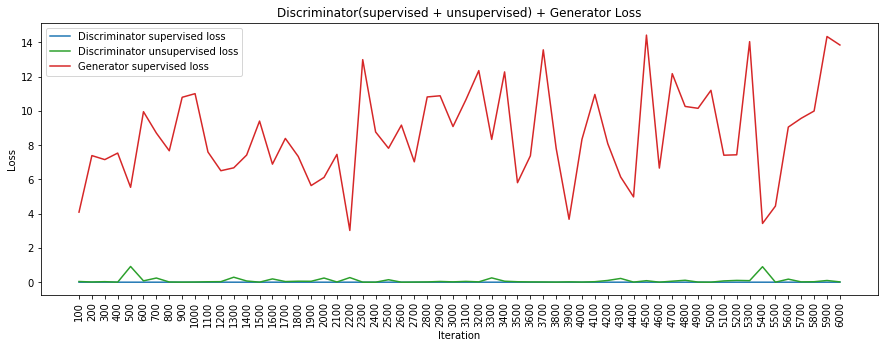

In [0]:
g_loss = np.array(losses_d)
d_loss = np.array(losses_d)

# Plot Discriminator supervised loss
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, d_loss, label="Discriminator loss", color='tab:blue')
plt.plot(iteration_checkpoints, g_loss, label="Generator loss", color='tab:green')

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Discriminator Loss + Generator Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()


# supervised_losses = np.array(supervised_losses)
# unsupervised_losses = np.array(unsupervised_losses)
# g_losses = np.array(g_losses)

# # Plot Discriminator supervised loss
# plt.figure(figsize=(15, 5))
# plt.plot(iteration_checkpoints, supervised_losses, label="Discriminator supervised loss", color='tab:blue')
# plt.plot(iteration_checkpoints, unsupervised_losses, label="Discriminator unsupervised loss", color='tab:green')
# plt.plot(iteration_checkpoints, g_losses, label="Generator supervised loss", color='tab:red')

# plt.xticks(iteration_checkpoints, rotation=90)

# plt.title("Discriminator(supervised + unsupervised) + Generator Loss")
# plt.xlabel("Iteration")
# plt.ylabel("Loss")
# plt.legend()

In [0]:
print(supervised_losses[-10:])

[0.00158508 0.00421892 0.00393993 0.0302744  0.0050643  0.00120058
 0.00076666 0.00052792 0.00463997 0.000655  ]


## SCGAN Classifier – Training and Test Accuracy 

In [0]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the training set
_, accuracy = discriminator_class.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

2000/2000 [==============================] - 0s 83us/step
Training Accuracy: 100.00%


In [0]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the test set
_, accuracy = discriminator_class.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

10000/10000 [==============================] - 1s 79us/step
Test Accuracy: 97.92%


## SCAGN - Generate Pictures

In [0]:
# model = load_model('./models/models-label-2000/generator-8000.h5')

In [0]:
# z = np.random.normal(0, 1, (batch_size, z_dim))
# fake_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
# fake_labels = to_categorical(fake_labels, num_classes=num_classes)
# gen_imgs = generator.predict([z, fake_labels])

def sample_images(image_grid_rows=2, image_grid_columns=5):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Get image labels 0-9
    fake_labels = [0,1,2,3,4,5,6,7,8,9]
    fake_labels_category = to_categorical(fake_labels, num_classes=num_classes)

    # Generate images from random noise
    gen_imgs = generator.predict([z, fake_labels_category])

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(10, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title("Digit: %d" % fake_labels[cnt])
            cnt += 1

In [0]:
def sample_images(label, image_grid_rows=2, image_grid_columns=5):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Get image labels 0-9
    fake_labels = [label]*10
    fake_labels_category = to_categorical(fake_labels, num_classes=num_classes)

    # Generate images from random noise
    gen_imgs = generator.predict([z, fake_labels_category])

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(10, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title("Digit: %d" % fake_labels[cnt])
            cnt += 1

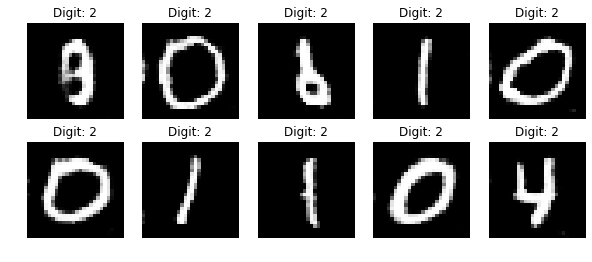

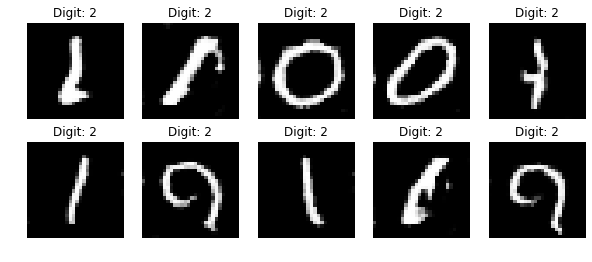

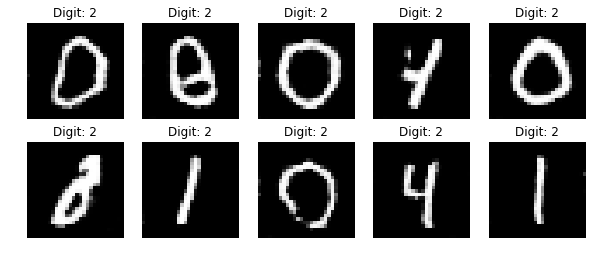

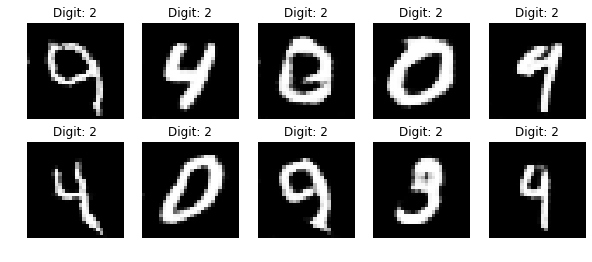

In [0]:
sample_images(2)
sample_images(2)
sample_images(2)
sample_images(2)

# Fully-Supervised Classifier

In [0]:
# Fully supervised classifier with the same network architecture as the SGAN Discriminator
mnist_classifier = build_discriminator_supervised(build_discriminator_net(img_shape))
mnist_classifier.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())

In [0]:
imgs, labels = dataset.training_set()
imgs = imgs[:num_labeled]
labels = labels[:num_labeled]

# One-hot encode labels
labels = to_categorical(labels, num_classes=num_classes)

# Train the classifier
training = mnist_classifier.fit(x=imgs,
                                y=labels,
                                batch_size=32,
                                epochs=200,
                                verbose=1)
losses = training.history['loss']
accuracies = training.history['acc']

Epoch 1/200
2000/2000 [==============================] - 5s 2ms/step - loss: 0.9853 - acc: 0.6775
Epoch 2/200
2000/2000 [==============================] - 0s 198us/step - loss: 0.3303 - acc: 0.8985
Epoch 3/200
2000/2000 [==============================] - 0s 199us/step - loss: 0.1916 - acc: 0.9470
Epoch 4/200
2000/2000 [==============================] - 0s 207us/step - loss: 0.1389 - acc: 0.9580
Epoch 5/200
2000/2000 [==============================] - 0s 209us/step - loss: 0.0821 - acc: 0.9770
Epoch 6/200
2000/2000 [==============================] - 0s 195us/step - loss: 0.0523 - acc: 0.9895
Epoch 7/200
2000/2000 [==============================] - 0s 198us/step - loss: 0.0395 - acc: 0.9905
Epoch 8/200
2000/2000 [==============================] - 0s 195us/step - loss: 0.0370 - acc: 0.9905
Epoch 9/200
2000/2000 [==============================] - 0s 205us/step - loss: 0.0298 - acc: 0.9925
Epoch 10/200
2000/2000 [==============================] - 0s 216us/step - loss: 0.0299 - acc: 0.9920
E

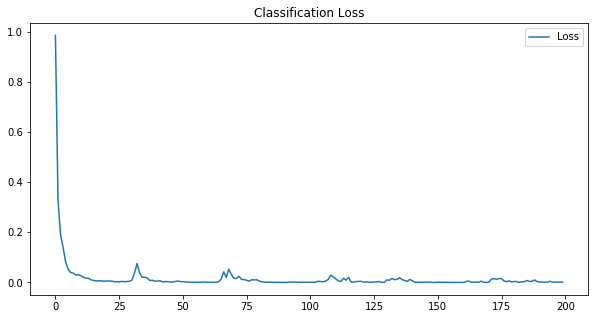

In [0]:
# Plot classification loss
plt.figure(figsize=(10, 5))
plt.plot(np.array(losses), label="Loss")
plt.title("Classification Loss")
plt.legend()

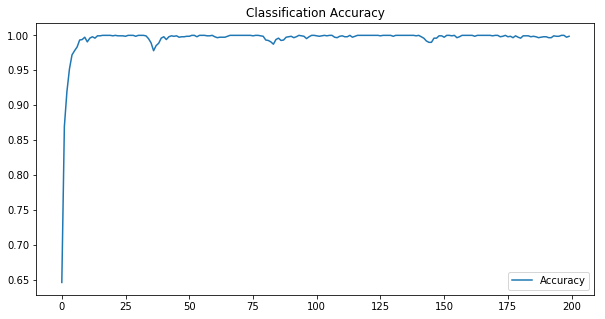

In [0]:
# Plot classification accuracy
plt.figure(figsize=(10, 5))
plt.plot(np.array(accuracies), label="Accuracy")
plt.title("Classification Accuracy")
plt.legend()

In [0]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the training set
_, accuracy = mnist_classifier.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

2000/2000 [==============================] - 2s 860us/step
Training Accuracy: 100.00%


In [0]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the test set
_, accuracy = mnist_classifier.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

10000/10000 [==============================] - 1s 79us/step
Test Accuracy: 96.00%


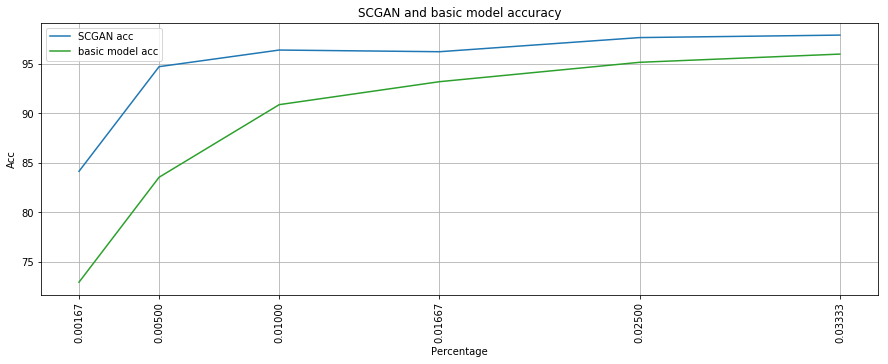

In [0]:
acc_scgan = np.array([84.15, 94.73, 96.41, 96.24, 97.67, 97.92])
acc_basic = np.array([72.94, 83.55, 90.89, 93.21, 95.17, 96.00])
per = [1/600, 1/200, 1/100, 1/60, 1/40, 1/30]
# Plot Discriminator supervised loss
plt.figure(figsize=(15, 5))
plt.plot(per, acc_scgan, label="SCGAN acc", color='tab:blue')
plt.plot(per, acc_basic, label="basic model acc", color='tab:green')

plt.xticks(per, rotation=90)

plt.title("SCGAN and basic model accuracy")
plt.xlabel("Percentage")
plt.ylabel("Acc")

plt.grid()
plt.legend()

---